**Projet 6 : Classifiez automatiquement des biens de consommation**

# Chargement et nettoyage

**Imports**

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 #opencv pour SIFT


pd.options.display.max_rows = 999

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import OneHotEncoder as ohe
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN


#from keras.preprocessing.image import load_img, img_to_array
#from keras.applications.vgg16 import preprocess_input
#from keras.applications.vgg16 import VGG16

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation
from keras.models import clone_model
from keras.preprocessing.image import ImageDataGenerator

from ipywidgets import IntProgress
from ipywidgets import Text
from IPython.display import display
from IPython.display import Image

from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

import time

In [5]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [6]:
data.shape

(1050, 15)

In [7]:
print(data.isna().sum())

uniq_id                      0
crawl_timestamp              0
product_url                  0
product_name                 0
product_category_tree        0
pid                          0
retail_price                 1
discounted_price             1
image                        0
is_FK_Advantage_product      0
description                  0
product_rating               0
overall_rating               0
brand                      338
product_specifications       1
dtype: int64


In [8]:
data = data[data['description'].notna()]
data = data[data['product_category_tree'].notna()]
data = data.drop_duplicates("description",keep='first', inplace=False, ignore_index=True)
data = data.reset_index(drop=True)
data

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ..."
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ..."
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented Polyvinyl Films...,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE5UVGW2JWVWCT,4500.0,1449.0,5912e037d12774bb73a2048f35a00009.jpg,False,Buy Uberlyfe Extra Large Pigmented Polyvinyl F...,No rating available,No rating available,Uberlyfe,"{""product_specification""=>[{""key""=>""Number of ..."
1048,c3edc504d1b4f0ba6224fa53a43a7ad6,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-medium-viny...,Wallmantra Medium Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >.

In [9]:
#suppression des colonnes qui n'ajoutent pas beaucoup d'informations à notre problème
data = data.drop(['uniq_id',
               'crawl_timestamp', 
               'product_url', 
               'pid', 
               'retail_price', 
               'discounted_price',
               'product_rating',
               'overall_rating',
               'is_FK_Advantage_product',
               'product_specifications'], axis = 1)

In [10]:
data = data[data['brand'].notna()]


In [11]:
data.shape

(712, 5)

In [12]:
# Definition of a function to apply or map
def get_categories_from_series(series):
    
    # --------------------------------------
    # Function to get the 3 first categories
    def get_categories_from_cell(cell):
        # Remove unwanted chars
        product_category_tree = cell.strip('[]"')

        # Get (at most) the 3 first categories of the category tree
        product_categories_list = product_category_tree.split(" >> ")
        
        # Initialization
        categories = pd.Series()
        
        # for each category, add a row
        for i in range(min(3, len(product_categories_list))):
            categories["cat_{}".format(i+1)] = product_categories_list[i]
        
        # return pd.Series with 3 rows
        return categories

    # ------------------------------------------------
    # Proceed to the split
    categories_df = series.apply(get_categories_from_cell).fillna("")

    # Return the frequency_encoding pd.DataFrame
    return categories_df

categories_df = get_categories_from_series(data['product_category_tree'])


# Add the columns of categories to the data DataFrame
data = pd.concat(
    [data, categories_df],
    sort=False,
    axis=1
)

# Display results
data.head(2)

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()
C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Serie

C:\Users\hp\AppData\Local\Temp\ipykernel_11560\73104589.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  categories = pd.Series()


,product_name,product_category_tree,image,description,brand,cat_1,cat_2,cat_3
0,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,Elegance,Home Furnishing,Curtains & Accessories,Curtains
1,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,Sathiyas,Baby Care,Baby Bath & Skin,Baby Bath Towels


# Données visuelles

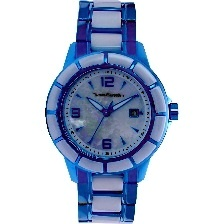

In [13]:
from IPython.display import Image
Image('data/Images/'+ str(data.sample(1)['image'].values.tolist()[0]), width=100 )

Ensuite, vous analyserez le jeu de données déjà constitué en réalisant un prétraitement des images et des descriptions des produits, une réduction de dimension, puis un clustering. Les résultats du clustering seront présentés sous la forme d’une représentation en deux dimensions à déterminer, qui ’illustrera le fait que les caractéristiques extraites permettent de regrouper des produits de même catégorie.

La représentation graphique vous aidera à convaincre Linda que cette approche de modélisation permettra bien de regrouper des produits de même catégorie.

Attention, Linda n’a pas besoin d’un moteur de classification à ce stade, mais bien d’une étude de faisabilité !


In [14]:
#Echantillon de données
img_echantillon = data.sample(50, random_state=10)

In [15]:
img_echantillon['image'] = img_echantillon['image'].apply(lambda x: 'data/Images/'+str(x))

In [16]:
img_echantillon['image'].head(1)

112    data/Images/8015db34d09642b046c775e8157dd729.jpg
Name: image, dtype: object

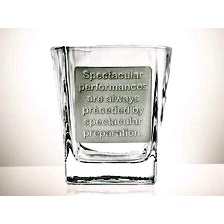

In [17]:
Image(img_echantillon.iloc[12]['image'], width=150)

In [18]:
img_echantillon.iloc[12]

product_name                                         giftsthatwow GTW-G-04
product_category_tree    ["Kitchen & Dining >> Bar & Glassware >> Bar G...
image                     data/Images/10ad262ebfdc8614e847d36e6fe9ecf9.jpg
description              Specifications of giftsthatwow GTW-G-04 (300 m...
brand                                                         giftsthatwow
cat_1                                                     Kitchen & Dining
cat_2                                                      Bar & Glassware
cat_3                                                          Bar Glasses
Name: 471, dtype: object

## Préambule : essai de convolution

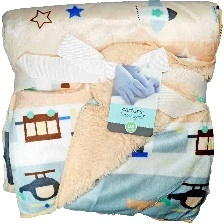

In [19]:
Image('data/Images/93618b8a998782d4d847ee5cba5c7de2.jpg', width=200)

In [20]:
img_conv = Image_PIL.open('data/Images/93618b8a998782d4d847ee5cba5c7de2.jpg')

In [21]:
img_conv = np.array(img_conv)

In [22]:
img_conv = cv2.resize(img_conv, (200,200))

In [23]:
def filtre_moyenneur(img, voisinage = 1):
    '''Remplace chaque pixel par l\'intensité moyenne de son voisinage'''
    etendue = 1+2*voisinage
    img2 = np.copy(img)
    
    for i in range(0, img.shape[0]):
        for j in range(0, img.shape[1]):
            if (i<voisinage)|(i>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            if (j<voisinage)|(j>img.shape[0] - voisinage-1):
                img2[i,j] = int(255/2)
            
            
    for i in range(voisinage,img.shape[0]-voisinage):
        for j in range(voisinage,img.shape[1]-voisinage):
            mean = 0
            for mean_x in range(i-voisinage, i+voisinage+1):
                for mean_y in range(j-voisinage, j+voisinage+1):
                    mean += img[mean_x, mean_y]
            img2[i,j] = mean/(etendue**2)
    
    
    return img2  

In [24]:
img_conv_traitee_1 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=1)
img_conv_traitee_2 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=2)
img_conv_traitee_3 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=3)
img_conv_traitee_4 = filtre_moyenneur(cv2.cvtColor(np.array(img_conv),cv2.COLOR_BGR2GRAY), voisinage=4)


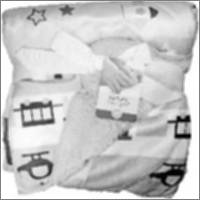

In [25]:
Image_PIL.fromarray(img_conv_traitee_1)

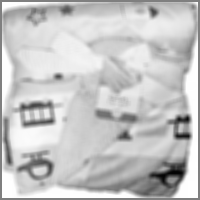

In [26]:
Image_PIL.fromarray(img_conv_traitee_2)

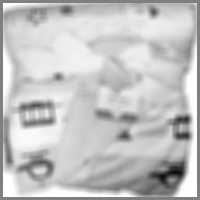

In [27]:
Image_PIL.fromarray(img_conv_traitee_3)

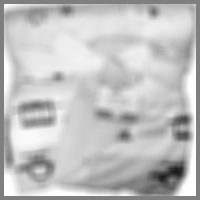

In [28]:
Image_PIL.fromarray(img_conv_traitee_4)

## Prétraitement

### Essais

**Réduction de bruit**

In [29]:
from scipy.ndimage import gaussian_filter
from PIL import Image as Image_PIL

In [30]:
im = np.array(Image_PIL.open(img_echantillon.iloc[12]['image']))

In [31]:
im = gaussian_filter(im, sigma=3)

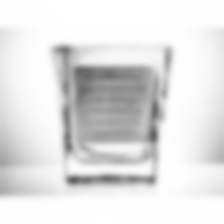

In [32]:
Image_PIL.fromarray(im)

**Egalisation**

In [33]:
hist, bins = np.histogram(im.flatten(), 256, [0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * hist.max() / cdf.max()

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


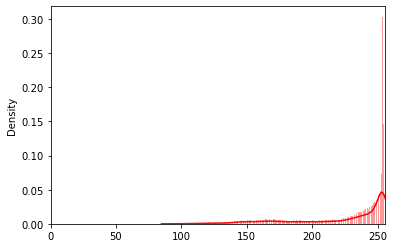

In [34]:
plt.figure(figsize=(6,4))
sns.distplot(im.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

In [35]:
cdf_m = np.ma.masked_equal(cdf,0)
cdf_m = (cdf_m - cdf_m.min())*255/(cdf_m.max()-cdf_m.min())
cdf = np.ma.filled(cdf_m,0).astype('uint8')

In [36]:
im2=cdf[im]

C:\Users\hp\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


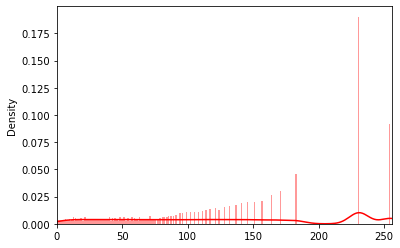

In [37]:
plt.figure(figsize=(6,4))
sns.distplot(im2.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.show()

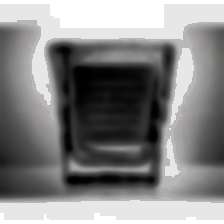

In [38]:
Image_PIL.fromarray(im2)

In [39]:
img3 = cv2.imread(img_echantillon.iloc[12]['image'],0)
equ = cv2.equalizeHist(img3)
res = np.hstack((img3,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)

True

In [40]:
img3.shape

(224, 224)

**Redimensionnement**

Taille d'origine des images

In [41]:
min_x = 100000
max_x = 0
min_y = 100000
max_y = 0
for image in img_echantillon['image'].tolist():
    shape = np.array(Image_PIL.open(image)).shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]

In [42]:
print('min_x {},\nmax_x {},\nmin_y {},\nmax_y {}'.format(min_x, max_x, min_y, max_y))

min_x 224,
max_x 224,
min_y 224,
max_y 224


Redimensionnement

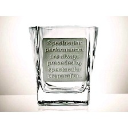

In [43]:
resize_img = cv2.resize(np.array(Image_PIL.open(img_echantillon.iloc[12]['image'])), dsize=(128,128))
Image_PIL.fromarray(resize_img)

### Fonction de prétraitement Complète

In [44]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    min_x = 100000
    max_x = 0
    min_y = 100000
    max_y = 0
    shape = array_im.shape
    if shape[0] < min_x:
        min_x = shape[0]
    elif shape[0] > max_x:
        max_x = shape[0]
    if shape[1] < min_y:
        min_y = shape[1]
    elif shape[1] > max_y:
        max_y = shape[1]
    im = cv2.resize(array_im, dsize=(width,height))
    del shape
    return im

In [45]:
def preprocess(image, path=False):
    '''prétraitement des images:
    * filtre gaussian
    * égalisation de l'histogramme
    * redimensionnement
    prend un entrée le chemin vers l'image et en sortie la matrice np.array de l'image traitée
    '''
    #ouverture du fichier
    if path == False: #si on a fourni un array en entree :
        im = image
    else: #si on a fourni un chemin vers le fichier en entree:
        im = np.array(Image_PIL.open(image))
    
    #greyscale
    im = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
    
    #flou gaussien
    im = gaussian_filter(im, sigma=2)
    
    #égalisation
    im = cv2.equalizeHist(im)
    
    return redim(im, 128, 128)

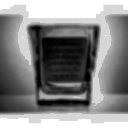

In [46]:
Image_PIL.fromarray(preprocess(img_echantillon.iloc[12]['image'], path=True))

## Extraction des caractéristiques (ORB)

In [47]:
import cv2 # opencv library for computer vision

orb = cv2.ORB_create()
model = orb

In [48]:
def get_descriptors(image_path):
    
    # load image and convert it to grayscale
    image = cv2.imread(image_path)
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # detect key points and descriptors
    keypoints, descriptors = model.detectAndCompute(img_gray, None)

    # returns keypoints and descriptors
    return keypoints, descriptors

In [49]:
dir_read = 'data/Images/'

# for each product in the data
for index, row in data.iterrows():
    
    # get url of the product's image
    img_name = row['image']
    
    # create the path to the image file
    img_path = os.path.join(dir_read, img_name)

(-0.5, 223.5, 223.5, -0.5)

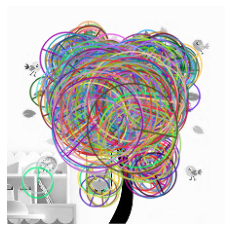

In [50]:
# get descriptors of the image
img_keypoints, img_descriptors = get_descriptors(img_path)

# get the image in gray
image = cv2.imread(img_path)
img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray)

# melt the image with keypoints
img_kp = cv2.drawKeypoints(
    image=img_gray,
    keypoints=img_keypoints,
    outImage=None,
    flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# show the grey image with keypoints
plt.imshow(img_kp)
plt.axis('off')

In [51]:
print("We get, for each image, {} keypoints and descriptors of {} dimensions."
      .format(img_descriptors.shape[0], img_descriptors.shape[1]))

We get, for each image, 440 keypoints and descriptors of 32 dimensions.


In [52]:
from PIL import Image
import os
import cv2 # opencv library for computer vision

# initializations
data.loc[:,'descriptors'] = pd.Series(index=data.index)


C:\Users\hp\AppData\Local\Temp\ipykernel_11560\3964205579.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  data.loc[:,'descriptors'] = pd.Series(index=data.index)


In [53]:
data['descriptors'] = data['descriptors'].astype(object)

In [54]:
# computing descriptors for each image of product
for index, row in data.iterrows():
    
    # get url of the product's image
    img_name = row['image']
    
    # create the path to the image file
    img_path = os.path.join(dir_read, img_name)
    
    # get the keypoints and descriptors of image
    img_keypoints, img_descriptors = get_descriptors(img_path)
    
    # add descriptors into a new column of the dataframe
    data.at[index, 'descriptors'] = img_descriptors

## CNN Données visuelles

### Report fonctions

In [55]:
def get_files(path_list):
    '''Renvoie la liste des matrices d\'images à partir d'une liste de chemins'''
    liste_image = []
    compteur = 0
    for image_path in path_list:
        #im = cv2.imread(image_path, 0)
        im = np.array(Image_PIL.open(image_path))
        liste_image.append(im)
        compteur +=1
    
    del compteur
    del im
    
    return liste_image

In [56]:
def redim(array_im, width, height):
    '''Redimensionne l\'image correspondant à array_im dans la largeur et la hauteur définie'''
    
    im = cv2.resize(array_im, dsize=(width,height))
        
    return im

### Données

In [118]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, random_state=42)

In [119]:
train['image'] = train['image'].apply(lambda x: 'data/Images/'+str(x))


In [92]:
test['image'] = test['image'].apply(lambda x: 'data/Images/'+str(x))


In [120]:
train['image']

634     data/Images/32da1bbf4f523bc8a8735701ce4b7726.jpg
603     data/Images/baa093d149982b010ab72ecbeec6110f.jpg
858     data/Images/fffa2117a4006d4a848eb7d5b80d4816.jpg
52      data/Images/f01140c02fd09e5c56312a64fa8db3da.jpg
367     data/Images/884ff6050ff3d6b2c8f681c300a21b2a.jpg
1027    data/Images/362714cbba2f5ae412d2f26bae99a266.jpg
397     data/Images/c2e71e7c97489d4efa5eab796ae354ac.jpg
463     data/Images/17582ae953860b5320683768b8e97d3a.jpg
1003    data/Images/0c70a580d96e50966130e2885d8c3505.jpg
211     data/Images/e99d9abb115a9bd580bcccf9ff4d4881.jpg
115     data/Images/8e8f5dc78f80eff3c77a9714303f59d2.jpg
80      data/Images/57578c1e6ec61a880a6f3f971f5f77b8.jpg
1010    data/Images/9ff54c12cc7ffd7c1a6724477b8fea2f.jpg
904     data/Images/a541b3aba326d7749b4c086c3cea9273.jpg
882     data/Images/a6c820b76bc29bbe2d85eecad3de03f8.jpg
442     data/Images/c6f4475e2385cc16ce83f21f975614b3.jpg
403     data/Images/b1c7aa8e0f50e7ee73ed30d12af1a961.jpg
354     data/Images/c8e2c85eccd

ValueError: The input data is not in a right format. Within your folder "data/Images/" there are no directories. Consult the documentation how to the folder structure should look like.

### Preprocessing the Training set

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)
training_set = train_datagen.flow_from_directory('/data/train',
                                                 target_size = (64, 64),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '/data/train'

### Initialising the CNN

In [105]:
cnn = tf.keras.models.Sequential()

### Step 1 - Convolution

In [106]:
cnn.add(tf.keras.layers.Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=[64, 64, 3]))

In [ ]:
### Step 2 - Pooling

In [93]:
train_cnn = get_files(train.copy()['image'].tolist())
test_cnn = get_files(test.copy()['image'].tolist())



In [94]:
len(train_cnn)

569

In [95]:
len(test_cnn)

143

In [96]:
redim(train_cnn[0], 128, 128).shape

(128, 128, 3)

In [97]:
redim(train_cnn[0], 128, 128).reshape(1,-1,3).shape

(1, 16384, 3)

In [98]:
train_array_cnn = np.vstack([redim(img, 128, 128).reshape(1,128,128,3) for img in train_cnn])
test_array_cnn = np.vstack([redim(img, 128, 128).reshape(1,128,128,3) for img in test_cnn])

In [99]:
train_array_cnn.shape

(569, 128, 128, 3)

In [102]:
train_cnn

[array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [100]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore')
array_cats = ohe.fit_transform(np.array(train['cat_1']).reshape(-1,1))

In [67]:
array_cats.todense().shape

(477, 7)

In [68]:
array_cats.shape

(477, 7)

In [69]:
train_array_cats = ohe.transform(train[['cat_1']]).todense()
test_array_cats = ohe.transform(test[['cat_1']]).todense()

C:\Users\hp\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(
C:\Users\hp\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but OneHotEncoder was fitted without feature names
  warnings.warn(


In [70]:
ohe.categories_

[array(['Baby Care', 'Beauty and Personal Care', 'Computers',
        'Home Decor & Festive Needs', 'Home Furnishing',
        'Kitchen & Dining', 'Watches'], dtype=object)]

### Construction Réseau

In [71]:
from keras.applications.vgg16 import preprocess_input

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Activation

In [72]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu', input_shape=(128,128,3,)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
model.compile(loss='mean_squared_error', optimizer='sgd')

In [73]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 7)                 2

### Entraînement

In [74]:
train_array_cnn.shape

(477, 128, 128, 3)

In [75]:
model_info = model.fit(train_array_cnn, train_array_cats, epochs=3, batch_size=40, verbose=2)

Epoch 1/3
12/12 - 6s - loss: 0.2653 - 6s/epoch - 532ms/step
Epoch 2/3
12/12 - 5s - loss: 0.2755 - 5s/epoch - 449ms/step
Epoch 3/3
12/12 - 6s - loss: 0.2827 - 6s/epoch - 468ms/step


In [76]:
for couche in model.get_weights():
    print(couche.shape)

(3, 3, 3, 32)
(32,)
(3, 3, 32, 32)
(32,)
(32768, 7)
(7,)


In [77]:
predictions_test = model.predict(test_array_cnn)

8/8 [==============================] - 1s 102ms/step


In [78]:
from sklearn.metrics import accuracy_score
accuracy_score(np.argmax(predictions_test, axis=1).reshape(-1,1), 
               np.argmax(test_array_cats, axis=1).reshape(-1,1))

0.02127659574468085

In [79]:
np.argmax(test_array_cats, axis=1).reshape(1,-1)

matrix([[2, 0, 2, 2, 4, 4, 2, 2, 3, 4, 4, 3, 4, 0, 2, 3, 3, 0, 2, 4, 4,
         2, 4, 2, 5, 1, 3, 2, 0, 0, 5, 3, 4, 0, 5, 3, 3, 2, 3, 4, 4, 2,
         0, 4, 0, 2, 0, 4, 0, 0, 2, 3, 4, 1, 2, 5, 0, 5, 0, 3, 5, 5, 4,
         0, 3, 1, 3, 5, 4, 3, 0, 2, 3, 0, 2, 2, 0, 1, 3, 0, 5, 0, 5, 2,
         3, 2, 2, 2, 4, 0, 2, 3, 3, 0, 5, 2, 4, 3, 6, 2, 2, 0, 3, 2, 5,
         1, 4, 2, 2, 3, 4, 1, 3, 6, 3, 0, 3, 3, 3, 0, 5, 4, 4, 5, 3, 2,
         4, 0, 2, 5, 4, 4, 4, 1, 5, 3, 0, 5, 2, 5, 3, 2, 3, 0, 5, 2, 5,
         2, 4, 2, 1, 5, 3, 2, 3, 0, 0, 4, 0, 2, 2, 2, 5, 2, 3, 0, 4, 3,
         2, 0, 1, 2, 3, 0, 4, 1, 2, 4, 4, 5, 4, 5, 0, 6, 4, 2, 2, 2, 1,
         3, 0, 4, 1, 0, 1, 2, 4, 3, 5, 0, 3, 3, 0, 5, 4, 3, 3, 4, 0, 5,
         2, 2, 5, 1, 5, 4, 4, 3, 3, 4, 3, 4, 1, 3, 6, 0, 5, 4, 4, 2, 6,
         4, 2, 3, 2]], dtype=int64)

In [80]:
np.argmax(predictions_test, axis=1)

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6], dtype=int64)

In [81]:
import zipfile
import tensorflow as tf
from glob import glob
import h5py

from tqdm import tqdm_notebook
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import load_model, Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input


%matplotlib inline
tf.__version__

'2.9.1'

In [82]:
IMG_SHAPE = (128, 128,3)

In [83]:
base_model = VGG16(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')


In [84]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [85]:
from keras.applications.vgg16 import preprocess_input
from keras.applications.vgg16 import VGG16
import h5py
vgg = VGG16()
vgg.layers.pop()
vgg.layers.pop()

vgg_transfer = Sequential()
vgg_transfer.add(vgg)
vgg_transfer.trainable = False
vgg_transfer.add(Dense(ohe.categories_[0].shape[0], activation='softmax'))
vgg_transfer.compile(loss='mean_squared_error', optimizer='sgd')

In [86]:
print('train array shape : ', train_array_cnn.shape)
print('train array cats : ', train_array_cats.shape)

train array shape :  (477, 128, 128, 3)
train array cats :  (477, 7)


In [88]:
vgg_transfer.fit(train_array_cnn, train_array_cats, epochs=3, batch_size=20, verbose=1)


Epoch 1/3


ValueError: in user code:

    File "C:\Users\hp\anaconda3\lib\site-packages\keras\engine\training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "C:\Users\hp\anaconda3\lib\site-packages\keras\engine\training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\hp\anaconda3\lib\site-packages\keras\engine\training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "C:\Users\hp\anaconda3\lib\site-packages\keras\engine\training.py", line 889, in train_step
        y_pred = self(x, training=True)
    File "C:\Users\hp\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\hp\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 224, 224, 3), found shape=(None, 128, 128, 3)


In [ ]:
vgg_transfer.load_weights('weighs_vgg_transfer.weights')
